In [51]:

import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from anytree import RenderTree
from lib.tree_functions import import_tree_from_json
from lib.config import pipeline_name, db_name, tree_json_path
import tempfile
from lib import count_plot
import networkx as nx

base_url = "https://cdl-segg.fra1.cdn.digitaloceanspaces.com/cdl-segg/"

### Download Section Tree

In [52]:
tree_url = base_url + tree_json_path
response = requests.get(tree_url)
response.raise_for_status()
with tempfile.NamedTemporaryFile(delete=False, suffix=".json") as temp_file:
    temp_file.write(response.content)
    path = temp_file.name
    root_node = import_tree_from_json(path)

for pre, fill, node in RenderTree(root_node):
    print(f"{pre}{node.name} ({node.data_id})")

Pimp my School Downloads (36)
├── 1.1. Was ist Schülervertretungsarbeit (38)
├── 1.2. Rechtliche Grundlagen (39)
│   ├── Mecklenburg-Vorpommern (41)
│   ├── Nordrhein-Westfalen (52)
│   │   └── Erlasse (55)
│   ├── Sachsen-Anhalt (53)
│   ├── Berlin (56)
│   │   ├── Besonderheiten Berufsschulen (57)
│   │   ├── Formales für Gremien (58)
│   │   └── Schülervertretung in Bezirk und Land (59)
│   ├── Hessen (132)
│   ├── Brandenburg (153)
│   └── Besonderheiten an einzelnen Schulformen (42)
│       ├── Oberstufenzentren (OSZ) (159)
│       ├── Grundschulen (173)
│       └── Berufsschule (176)
├── 1.3. Mögliche Aktionen, Themen und Projekte von A-Z (46)
│   ├── Unterricht verändern (47)
│   ├── Projektideensammlungen zur Inspiration (111)
│   ├── Aktionen und Projekte (Beschreibungen) (51)
│   │   ├── Lesenacht (105)
│   │   ├── Party (106)
│   │   ├── Schulball (107)
│   │   ├── Schülernachhilfe-Pool (108)
│   │   ├── Valentinstag (109)
│   │   ├── Schülerfirma (160)
│   │   └── Vera

### Download Files

In [53]:
posts_url = base_url + "smoke_test_downloads.parquet"
response = requests.get(posts_url)
response.raise_for_status()
df = pl.read_parquet(response.content)
df.head()

data_id,data_category_id,title,category_title,download_link,file_type,file_binary
i64,i64,str,str,str,str,binary
9281,80,"""Hass in der Demokratie begegne…","""4.5. Reale politische Interess…","""https://meinsvwissen.de/downlo…","""pdf""","b""%PDF-1.4\x0d%\xe2\xe3\xcf\xd3\x0d\x0a9427\x200\x20obj\x0d<</Linearized\x201/L\x202878133/O\x209430/""…"
3947,88,"""Erklärvideo 2 - Klassensprech…","""2.1.1. Klassensprecher_innen""","""https://meinsvwissen.de/downlo…","""mp4""","b""\x00\x00\x00\x18ftypmp42\x00\x00\x00\x00isommp42\x00\x00\xfe\xccmoov\x00\x00\x00lmvhd\x00\x00\x00\x00\xd8\x83r2\xd8\x83r2\x00\x002\x00\x00\x20:\x0c""…"
3937,88,"""Vorlage. Evaluation nach 3 Mon…","""2.1.1. Klassensprecher_innen""","""https://meinsvwissen.de/downlo…","""pdf""","b""%PDF-1.5\x0a%\xc7\xec\x8f\xa2\x0a6\x200\x20obj\x0a<</Length\x207\x200\x20R/Filter\x20/FlateDecode>>""…"
3941,88,"""Wahlprotokoll_einfach""","""2.1.1. Klassensprecher_innen""","""https://meinsvwissen.de/downlo…","""pdf""","b""%PDF-1.5\x0d\x0a%\xb5\xb5\xb5\xb5\x0d\x0a1\x200\x20obj\x0d\x0a<</Type/Catalog/Pages\x202\x200\x20R/Lang(d""…"
9279,178,"""Positioniert euch! Politisches…","""Rechtsextremismus an der Schul…","""https://meinsvwissen.de/downlo…","""pdf""","b""%PDF-1.5\x0d%\xe2\xe3\xcf\xd3\x0d\x0a221\x200\x20obj\x0d<</Linearized\x201/L\x201337926/O\x20223/E\x20""…"


In [54]:
df["file_type"].value_counts().sort("count", descending=True)

file_type,count
str,u32
"""pdf""",44
"""octet-stream""",5
"""mp4""",3


### Posts

In [55]:
posts_url = base_url + "posts.parquet"
response = requests.get(posts_url)
response.raise_for_status()
df = pl.read_parquet(response.content)
df.head()

id,date,title,stage,tool_types,topics,download_chapter_dedicated,download_chapters_further,book_chapter,related_posts
i64,date,str,str,list[cat],list[str],i64,list[i64],str,list[i64]
5656,2022-05-03,"""Wegweiser: Wie kann ich andere…","""sv-alltag""","[""infografik""]","[""mehr-werden"", ""motivation""]",null,[65],"""https://meinsvwissen.de/wp-con…","[7700, 5237, … 4593]"
4889,2022-03-20,"""SV macht Klimaschutz""","""profis""","[""video""]","[""ideenfindung"", ""projektarbeit""]",161,[],null,[6954]
5237,2022-03-30,"""Projektplan Vorlage""","""sv-alltag""","[""download"", ""vorlage""]","[""projektarbeit""]",70,[],"""https://meinsvwissen.de/wp-con…","[6954, 7700, … 3421]"
5980,2022-06-08,"""Rechte NRW""","""grundlagen""","[""praesentation""]","[""rechte""]",52,[],null,"[3421, 4593, … 6588]"
8952,2025-07-31,"""Memory-Spiel: Konferenzen (Mec…","""sv-alltag""","[""download"", ""vorlage""]","[""gremien-konferenzen""]",41,[],null,"[6588, 3421, … 6588]"


In [56]:
len(df)

86

In [57]:
df["stage"].value_counts().sort("count", descending=True)

stage,count
str,u32
"""sv-alltag""",31
"""grundlagen""",29
"""fortgeschrittene""",13
"""profis""",8
null,5


In [58]:
df["stage"].unique().to_list()

['fortgeschrittene', 'grundlagen', 'sv-alltag', None, 'profis']

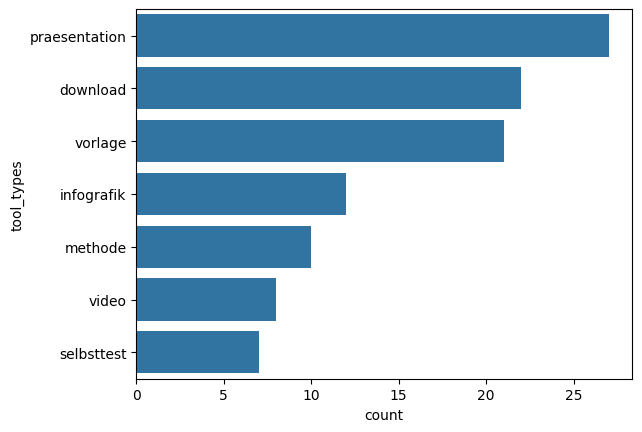

In [59]:
count_plot(df, "tool_types")

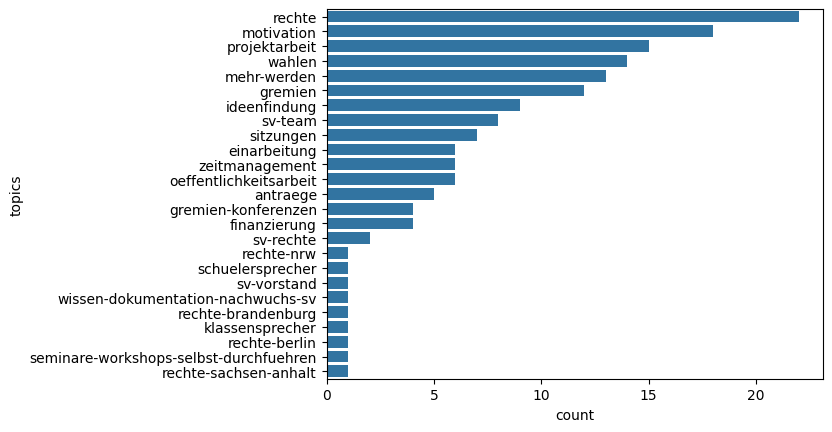

In [60]:
count_plot(df, "topics")

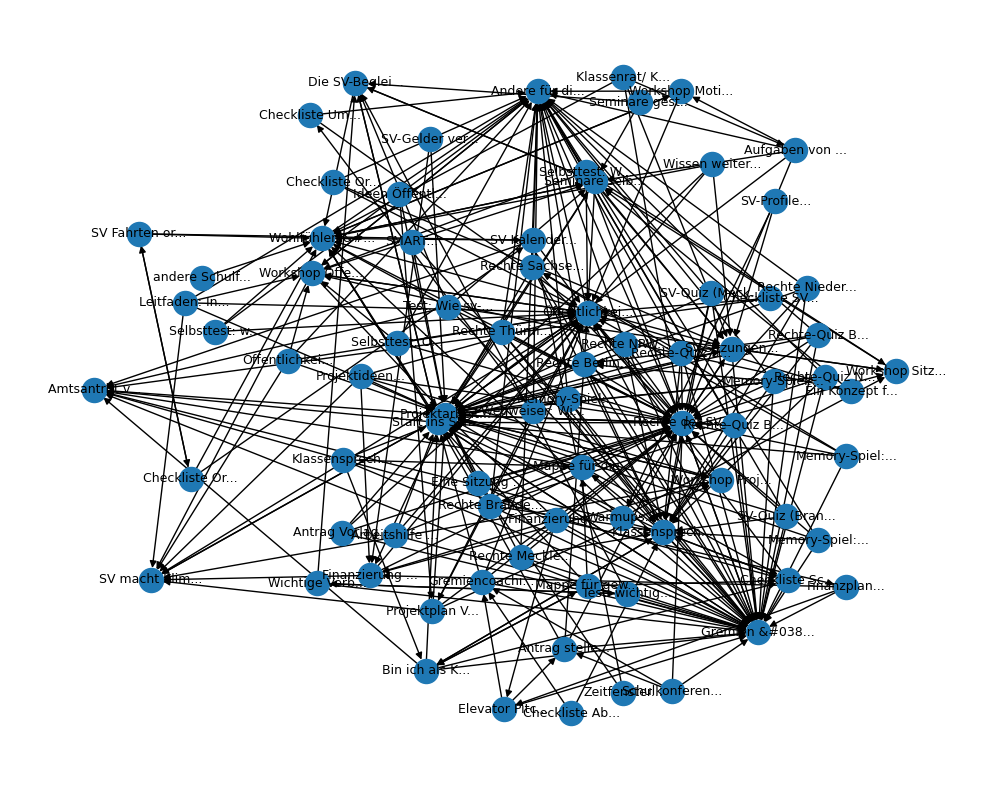

In [61]:
records = df.to_dicts()

G = nx.DiGraph()
for rec in records:
    src = rec["id"]
    G.add_node(src, label=f"{rec['title'][:13]}...")
    for tgt in rec.get("related_posts") or []:
        G.add_edge(src, tgt)

nodes_to_remove = [n for n, d in G.degree() if d <= 1]
G.remove_nodes_from(nodes_to_remove)

# Use spring layout instead of pygraphviz
pos = nx.spring_layout(G, k=1, iterations=50)

plt.figure(figsize=(10, 8))
nx.draw_networkx_nodes(
    G,
    pos,
)
nx.draw_networkx_edges(
    G,
    pos,
)
labels = nx.get_node_attributes(G, "label")
nx.draw_networkx_labels(G, pos, labels, font_size=9, font_family="sans-serif")

plt.axis("off")
plt.tight_layout()
plt.show()

In [62]:
self_loop_nodes = [n for n in G.nodes() if G.has_edge(n, n)]

# 2. Or via self-loop edges
self_loop_nodes = list({u for u, v in nx.selfloop_edges(G)})

print("Node IDs with self-loops:", self_loop_nodes)


Node IDs with self-loops: []


### Sections

In [63]:
posts_url = base_url + "sections.parquet"
response = requests.get(posts_url)
response.raise_for_status()
df = pl.read_parquet(response.content)
df.head()

post_id,title,text,type,external_link,transcript_url
i64,str,str,cat,str,str
5237,null,"""Erstellt in dieser Ausfüllvorl…","""plain_text""",null,null
5237,"""Projektplan Vorlage""",null,"""h5p""",null,null
4889,null,"""Nachhaltigkeit und Klimaschutz…","""plain_text""",null,null
4889,""" Übersicht: Klimaschutz, Nachh…",null,"""accordion_section_prezi""","""https://prezi.com/i/view/GBfu7…",null
4889,null,null,"""accordion_section_youtube""","""https://www.youtube.com/embed/…",null


In [64]:
df["type"].value_counts().sort("count", descending=True)

type,count
cat,u32
"""accordion_section_text""",194
"""plain_text""",92
"""accordion_section_image""",90
"""flipcard""",60
"""accordion_section_prezi""",37
…,…
"""h5p""",26
"""image""",19
"""youtube""",7


### Glossary Terms

In [65]:
posts_url = base_url + "glossary_terms.parquet"
response = requests.get(posts_url)
response.raise_for_status()
df = pl.read_parquet(response.content)
df.head()

term,definition,DE,DE_BW,DE_BY,DE_BE,DE_BB,DE_HB,DE_HH,DE_HE,DE_MV,DE_NI,DE_NW,DE_RP,DE_SL,DE_SN,DE_ST,DE_SH,DE_TH
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""Antrag""","""Ein Antrag ist ein Vorschlag, …",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""Aufgabenprofil""","""Ihr schreibt transparent und k…",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""Auftaktveranstaltung / SV-Tag""","""Start in die SV-Arbeit zu Begi…","""Start in die SV-Arbeit zu Begi…",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""Bezirks-/ Kreis & Landesschüle…",null,"""BSK (Bundesschülerkonferenz – …",null,null,"""BSA und LSA (Bezirksschüler- u…","""KSR und LSR (Kreisschüler- und…",null,null,null,"""KSR und LSR (Kreisschüler- und…",null,"""BSV und LSV (Bezirksschüler- u…",null,null,null,"""KSR und LSR (Kreisschüler- und…",null,"""Kreisschülersprecher:innen und…"
"""BSK""","""Bundesschülerkonferenz. Sie be…","""Bundesschülerkonferenz. Sie be…",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null


### Publications

In [66]:
posts_url = base_url + "publications.parquet"
response = requests.get(posts_url)
response.raise_for_status()
df = pl.read_parquet(response.content)
df.head()

key,type,title,authors,abstract,date,url,pdf_binary,jurisdiction,school_type,tags
str,str,str,list[str],str,str,str,binary,cat,cat,list[str]
"""21001957/D794UHKJ""","""book""","""Pimp my school : 1x1 der SV-Ar…","[""Felix Scheel""]","""Das Handbuch greift alle klass…","""2023-08""","""https://collections.fes.de/pub…","b""%PDF-1.7\x0d%\xe2\xe3\xcf\xd3\x0d\x0a4814\x200\x20obj\x0d<</Linearized\x201/L\x207810875/O\x204816/""…","""DE_MV""",null,[]
"""21001957/MRSKJQKT""","""book""","""Rechtsextremismus & Schule: Th…","[""Schule ohne Rassismus – Schule mit Courage""]",null,"""2024""","""https://www.schule-ohne-rassis…","b""%PDF-1.7\x0d%\xe2\xe3\xcf\xd3\x0d\x0a1320\x200\x20obj\x0d<</Linearized\x201/L\x209313914/O\x201325/""…",null,null,null
"""21001957/GBX9H2JU""","""article""","""Handbuch für Klassensprecher*i…","[""Jugendbildungsstätte Kurt Löwenstein""]",null,"""2024""","""https://www.kurt-loewenstein.d…","b""%PDF-1.6\x0d%\xe2\xe3\xcf\xd3\x0d\x0a1\x200\x20obj\x0d<</Lang(de-DE)/Metadata\x202\x200\x20R/Output""…","""DE_BE""","""elementary""",[]


In [67]:
df["type"].value_counts().sort("count", descending=True)

type,count
str,u32
"""book""",2
"""article""",1


In [68]:
df["jurisdiction"].value_counts()

jurisdiction,count
cat,u32
null,1
"""DE_MV""",1
"""DE_BE""",1


### Legal Resources

In [69]:
posts_url = base_url + "legal_resources.parquet"
response = requests.get(posts_url)
response.raise_for_status()
df = pl.read_parquet(response.content)
df.head()

url,type,title,html,jurisdiction
str,str,str,str,cat
"""https://gesetze.berlin.de/perm…","""Schulgesetz""","""SchulG""",""" <a name=""DocInhalt""> </a> <…","""DE_BE"""
"""https://bravors.brandenburg.de…","""Schulgesetz""","""BbgSchulG""",""" <ul> <li><a>Ansicht drucken…","""DE_BB"""
"""https://landesrecht.thueringen…","""Schulgesetz""","""ThürSchulG""",""" <a name=""DocInhalt""> </a> <…","""DE_TH"""
"""https://landesrecht.thueringen…","""Schulordnung""","""ThürSchulO""",""" <a name=""DocInhalt""> </a> <…","""DE_TH"""
"""https://www.landesrecht.sachse…","""Schulgesetz""","""SchulG LSA""",""" <a name=""DocInhalt""> </a> <…","""DE_ST"""


In [70]:
df["type"].value_counts(sort=True)

type,count
str,u32
"""Schulgesetz""",14
"""Runderlass""",4
"""Schulordnung""",2
"""Schülermitwirkungsverordnung""",1
"""Schülermitverantwortungsverord…",1
…,…
"""Verordnung zur Gestaltung des …",1
"""Schülerwahlordnung""",1
"""Verwaltungsvorschrift""",1


### Student Council Committees

In [77]:
scc_url = base_url + "student_council_committees.parquet"
response = requests.get(scc_url)
response.raise_for_status()
scc_df = pl.read_parquet(response.content)
scc_df.head()

name,description,jurisdiction,website
str,str,cat,str
"""Bundesweit""","""Die Bundesschülerkonferenz ist…","""DE""","""https://www.bundesschuelerkonf…"
"""Baden-Württemberg""","""Der Landesschülerbeirat (LSBR)…","""DE_BW""","""https://lsbr.de/"""
"""Bayern""","""Die SchĂĽlermitverantwortung (…","""DE_BY""","""https://www.facebook.com/lsrba…"
"""Brandenburg""","""Beim Landesschüler*innenrat Br…","""DE_BB""","""https://www.lsr-brandenburg.de"""
"""Berlin""","""Der Landesschüler*innenausschu…","""DE_BE""","""https://lsaberlin.de/"""


In [72]:
print(f"Total SCC entries: {len(scc_df)}")
print(f"Jurisdictions covered: {len(scc_df['jurisdiction'].unique())}")
print("Sample jurisdictions:", scc_df['jurisdiction'].unique().to_list()[:5])

Total SCC entries: 17
Jurisdictions covered: 17
Sample jurisdictions: ['DE', 'DE_BW', 'DE_BY', 'DE_BB', 'DE_BE']


### SV tipps

In [73]:
svtipps_url = base_url + "svtipps.parquet"
response = requests.get(svtipps_url)
response.raise_for_status()
svtipps_df = pl.read_parquet(response.content)
svtipps_df.head()

title,url,html_content,category,subcategory
str,str,str,str,str
"""Struktur – SVTipps – Von Schül…","""https://svtipps.de/struktur/""","""<h1>Struktur</h1><p>Ihr wollt,…","""Struktur""",null
"""Die Schülervertretung – SVTipp…","""https://svtipps.de/struktur/di…","""<h1>Die Schülervertretung</h1>…","""Struktur""",null
"""Schulsprecher*in – SVTipps – V…","""https://svtipps.de/struktur/sc…","""<h1>Schulsprecher*in</h1><p>Di…","""Struktur""",null
"""Klassensprecher*in & Stufenspr…","""https://svtipps.de/struktur/kl…","""<h1>Klassensprecher*in &amp; S…","""Struktur""",null
"""Kassenwart – SVTipps – Von Sch…","""https://svtipps.de/struktur/ka…","""<h1>Kassenwart</h1><p>Der Kass…","""Struktur""",null


In [74]:
print(f"Total SVTipps entries: {len(svtipps_df)}")
print(f"Categories: {len(svtipps_df['category'].unique())}")
svtipps_df['category'].value_counts().head()

Total SVTipps entries: 97
Categories: 7


category,count
str,u32
"""Kleinprojekte""",31
"""Projektmanagement""",5
"""Großprojekte""",39
"""Management""",8
"""Sonstiges""",3
